In [1]:
from cppbridge import *
from mcmc_analytics import * 
plt.rcParams['font.size'] = '16'

In [2]:
%load_ext autoreload
%autoreload 2

The samplers in this notebook are from the paper\
[1] Shestopaloff A.Y, Neal R.M. Sampling Latent States for High-Dimensional Non-Linear State Space Models with the Embedded HMM Method

# Testing Metropolitan and EHMM samplers with linear Gaussian models
## Models specification

In [3]:
# Set up the transition model with known parameters
T = 250
n = 10
A = DiagonalMatrixParam() 
A.value = np.eye(n) * 0.9
Q = SymmetricMatrixParam()
Q.value = np.ones((n,n)) * 0.7 + np.eye(n) * 0.3
prior_mean = np.zeros(n)
Q_init = Q.value * (1/(1-0.9*0.9))
trm = TransitionSpec(A, Q, prior_mean, Q_init)

In [4]:
# Set up the observation model with known parameters
C = DiagonalMatrixParam()
C.value = -0.4 * np.eye(n)
R = DiagonalMatrixParam()
R.value = np.eye(n)
obsm = ObservationSpec(ModelType.LINEAR_GAUSS, C, R)

## Sampler specification
We check the two sampling schemes to sample from the distribution of the latent states: Metropolis single state update, and embedded HMM method, described in [1]. As the resulting states' distribution is Gaussian (as both transition and observation models are Gaussian) we can use a Kalman smoother to find exact solution and then compare it to the results produced by the samplers
### Metropolis sampling scheme
The scheme samples one state at a time, with all dimensions at once, conditional on all other states $x_{-t}=(x_{1},...,x_{t-1},x_{t+1},...,x_{n})$, using autoregressive update of the form described in [1].

In [5]:
# Specify metropolis scheme
met_sampler = SamplerSpec(SamplerType.METROPOLIS)

### Embedded HMM sampling scheme
This scheme was proposed in [1] and uses forward pool state selection. Each sampling step samples the whole sequence at once, selecting a state from the pool of states at each time. To generate the pool for each time the scheme uses autoregressive and shift updates. If specified it can alternate between updates on original and the reversed observations sequence.

In [6]:
# Specify EHMM scheme
pool_sz = 50
ehmm_sampler = SamplerSpec(SamplerType.EHMM, pool_size=pool_sz)

## Observations 
Finally, we need the observations, on which to run the samplers. The data we use is the synthetic data, generated in `models.ipynb` notebook with the same parameters.

In [7]:
# We use the data file generated previously
dg = DataGenerator(trm, obsm, T, 0)
datafile = f"{dg.modelhash}_data.h5"
dataspec = Data(datafile)

## Simulation
### Single-state Metropolis MCMC
At first we run the Metropolis single state sampler and compare the results with the Kalman smoother results. This will establish a benchmark for further experiments. We will also run the EHMM sampler and compare its results with our benchmark as well as with the single state sampler.

To run the simulation we need to provide the initial sample $\mathbf{x}_0$ to start off the sampler, and specify the parameters of the simulation. We set $\mathbf{x}_0=\mathbf{0}$ for this model and scheme. We run 5 simulations for $10^6$ iterations each, starting with the different seed for randomisation. To save memory we thin the sampling, only recording each tenth sample.

In [8]:
n_iter_met = int(1e6)
x_init = np.zeros((n, T))
seeds = np.array([1, 10, 100, 1e4, 1e5], dtype=int)
scales_met = np.array([0.2, 0.8])
thinning = 10
simulation_met = SimulationSpec(n_iter_met, seeds, x_init, thinning=thinning, scaling=scales_met)

In [9]:
# Run simulation with Metropolitan single state sampler
met_session_name = f"met_noreverse_{dg.modelhash}"
mcmc_met_lg = MCMCsession(met_session_name)
if mcmc_met_lg.hasResults():
    mcmc_met_lg.loadResults() # <-- NB! Each file is ~2GB so it takes time to download
else:
    mcmc_met_lg.init(T, trm, obsm, met_sampler, simulation_met, dataspec)
    mcmc_met_lg.run()

Loading results for seed10000...		Done
Loading results for seed100000...		Done
Loading results for seed10...		Done
Loading results for seed100...		Done
Loading results for seed1...		Done


### Embedded HMM MCMC
We now run the EHMM sampler. As with the single state sampler, we set $\mathbf{x}_0=\mathbf{0}$ for this model and scheme. We run 5 simulations for $10000$ iterations each, starting with the different seed for randomisation (we use the same seeds as for single state sampler). Each iteration will run on both original and reversed sequence of observations.

In [ ]:
n_iter_ehmm = 10000
scales_ehmm = np.array([0.1, 0.5])
reverse = True
simulation_ehmm = SimulationSpec(n_iter_ehmm, seeds, x_init, scaling=scales_ehmm, reverse=reverse)

In [ ]:
# Run simulation with EHMM sampler
ehmm_session_name = f"ehmm50_noflip_reverse_{dg.modelhash}"
mcmc_ehmm_lg = MCMCsession(ehmm_session_name)
if mcmc_ehmm_lg.hasResults():
    mcmc_ehmm_lg.loadResults()
else:
    mcmc_ehmm_lg.init(T, trm, obsm, ehmm_sampler, simulation_ehmm, dataspec)
    mcmc_ehmm_lg.run()

## Kalman smoother
To check the validity of the samplers above we calculate the distribution of the latent states via Kalman smoother, which will give us the density $p(x_{t}|y_{1:T})\text{ at each time }t$. We will use information filter scheme to to find $p(x_{t}|y_{1:t})$ and then so-called "two-filter" scheme to find the smoothing distribution $p(x_{t}|y_{1:T})$. These results can then be compared with the results of the samplers to ensure they converge to the correct distribution.

In [ ]:
kalmanspec = SmootherSpec(FilterType.INFORMATION, SmootherType.TWOFILTER)

In [ ]:
# Run Kalman smoother
kalman_session_name = "kalman_10x250_v1"
kalman_lg = KalmanSession(kalman_session_name)
if kalman_lg.hasResults():
    kalman_lg.loadResults()
else:
    kalman_lg.init(T, trm, obsm, kalmanspec, dataspec)
    kalman_lg.run()

---
## Analysis of the results
### Overview

In [ ]:
met_burnin = int(0.1 * (n_iter_met/thinning + 1))
ehmm_burnin = int(0.1 * 2 * (n_iter_ehmm + 1)) # <-- as we run on reversed sequence, too, there will be twice as many samples
 
met_samples = mcmc_met_lg.getSamples(met_burnin)
ehmm_samples = mcmc_ehmm_lg.getSamples(ehmm_burnin)

In [ ]:
ac_ehmm = getACF(mcmc_ehmm_lg.samples, ehmm_samples)
taus_ehmm = 1 + 2*np.sum(ac_ehmm, axis=2)
meantaus_ehmm = np.mean(taus_ehmm)

ac_met = getACF(mcmc_met_lg.samples, met_samples)
taus_met = 1 + 2*np.sum(ac_met, axis=2)
meantaus_met = np.mean(taus_met)

In [ ]:
met_overview = {"Num seeds": len(seeds),
                "Num iter": n_iter_met, 
                "Time per sample, ms": np.mean(list(mcmc_met_lg.durations.values()))/list(mcmc_met_lg.samples.values())[0].shape[0], 
                "Acceptance rate, %": 100 * np.mean(list(mcmc_met_lg.acceptances.values()))/n_iter_met,
                "Average autocorrelation time": meantaus_met
               }

ehmm_met_acc = 100 * np.mean([acc[:T].mean() / (n_iter_ehmm * pool_sz * (1 + reverse)) for _, acc in mcmc_ehmm_lg.acceptances.items()])
ehmm_shift_acc = 100 * np.mean([acc[T+1:].mean() / (n_iter_ehmm * pool_sz * (1 + reverse)) for _, acc in mcmc_ehmm_lg.acceptances.items()])
ehmm_overview = {"Num seeds": len(seeds),
                "Num iter": n_iter_ehmm, 
                "Time per sample, ms": np.mean(list(mcmc_ehmm_lg.durations.values()))/list(mcmc_ehmm_lg.samples.values())[0].shape[0], 
                "Acceptance rate, %": (ehmm_met_acc, ehmm_shift_acc),
                "Average autocorrelation time": meantaus_ehmm
               }
overview = pd.DataFrame({"Single-state Metropolis":met_overview, "Embedded HMM":ehmm_overview}).T
overview

In [ ]:
met_ar = np.array(list(mcmc_met_lg.acceptances.values())).ravel() / n_iter_met
ehmm_ar = np.stack(list(mcmc_ehmm_lg.acceptances.values()), axis=1)[:T].ravel() / (n_iter_ehmm * pool_sz * (1 + reverse))
ehmm_shift = np.stack(list(mcmc_ehmm_lg.acceptances.values()), axis=1)[T+1:].ravel() / (n_iter_ehmm * pool_sz * (1 + reverse))
pd.DataFrame(dict(met_ar=met_ar, ehmm_ar=ehmm_ar, ehmm_shift=np.append(ehmm_shift, [np.nan]*len(seeds)))).describe()

In [ ]:
overview.to_latex(OUTPUTS_PATH/"overview_lg.tex", column_format="rrrrrr", escape=True, caption="Overview of the two samplers")

In [ ]:
# Plot the states and the observations for all dimensions across time
xs = np.array(range(1, T+1))
for name, series in {"y":dg.observations, "x":dg.states}.items():
    fig, ax = plt.subplots(figsize=(8,5))
    for i in range(n):
        ax.plot(xs, series[i, :], color=f'C{i}')
    ax.set_xmargin(0.01)
    ax.set_xlabel("time $t$")
    ax.set_ylabel(f"${{{name}}}$")
    plt.tight_layout()
    plt.savefig(OUTPUTS_PATH/f"generated_{name}s.png", dpi=300, format='png')
    plt.show();

In [ ]:
# Show states and observations for couple of dimensions vs Kalman smoothed mean for the same dimensions
dims = np.random.choice(range(n), 2, replace=False)
xs = np.array(range(1, T+1))
for d in dims:
    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(xs, dg.states[d, :])
    ax.plot(xs, kalman_lg.means[:, d])
    ax.scatter(xs, dg.observations[d, :])
    ax.set_xmargin(0.01)
    ax.set_xlabel("time $t$")
    ax.set_ylabel("$x,y$")
    plt.tight_layout()
    plt.show();

### Test equality of means
Compare Kalman's smoothed means with means of samples from both samplers, perform z-test

In [ ]:
zt_met = ztest(met_samples, kalman_lg.means, kalman_lg.covariances)
zt_ehmm = ztest(ehmm_samples, kalman_lg.means, kalman_lg.covariances)

In [ ]:
def plot_meansdiff(samples, sname):
    diffs = np.log(np.abs(np.mean(samples, axis=0))) - np.log(np.abs(kalman_lg.means))
    fig, ax = plt.subplots(figsize=(8,5))
    xs = np.array(range(1, T+1))
    for d in range(n):
        ax.plot(xs, diffs[:, d], label=f"dim {d}")
    ax.legend(ncol=n//3, loc="best")
    ax.set_ylim((-1.55, None))
    ax.set_xmargin(0.01)
    plt.tight_layout()
    plt.savefig(OUTPUTS_PATH/f"{sname}_means_diffs.png", dpi=300, format='png')
    plt.show()
    return np.mean(diffs)

In [ ]:
plotStatTest(zt_met, save="met")

In [ ]:
plotStatTest(zt_ehmm, save="ehmm")

In [ ]:
plot_meansdiff(met_samples, "met")

In [ ]:
plot_meansdiff(ehmm_samples, "ehmm")

In [ ]:
fig, axs = plt.subplots(3, 4, figsize=(12,10))
for dim in range(n):
    i = dim // 4
    j = dim % 4
    pd.DataFrame({"kalman":kalman_lg.means[:,dim], "met":np.mean(met_samples, axis=0)[:,dim]})\
                .plot('kalman', 'met', kind='scatter', grid=True, ax=axs[i,j], title=f"Dim {dim}")

In [ ]:
diffs = np.log(np.abs(np.mean(met_samples, axis=0))) - np.log(np.abs(kalman_lg.means))
np.where(diffs[:,4]<-.5)

In [ ]:
t = 235
d = 4
print(kalman_lg.means[t,d])
print(np.mean(met_samples, axis=0)[t, d])

### Trace plots  

In [ ]:
for seed, series in mcmc_met_lg.samples.items():
    print("\n", seed, ":")
    params= plotTrace(series, t, d, fitnorm=True, kalman=kalman_lg)
    print(f"Kalman params:{', '.join([k + '=' + str(v) for k, v in params['exact'].items()])}")
    print(f"Sample fitted params:{', '.join([k + '=' + str(v) for k, v in params['fitted'].items()])}")
print("\Aggregate across seeds:")
params = plotTrace(met_samples, t, d, fitnorm=True, kalman=kalman_lg)
print(f"Kalman params:{', '.join([k + '=' + str(v) for k, v in params['exact'].items()])}")
print(f"Sample fitted params:{', '.join([k + '=' + str(v) for k, v in params['fitted'].items()])}")

In [ ]:
plotTrace(ehmm_samples, t, d, fitnorm=True, kalman=kalman_lg, save="ehmm")

In [ ]:
plotTrace(met_samples, t, d, fitnorm=True, kalman=kalman_lg, save="met")

### Test normality
#### Marginals: univariate normality 

In [15]:
nt_met = norm_test(met_samples, kalman_lg.means, kalman_lg.covariances)
nt_ehmm = norm_test(ehmm_samples, kalman_lg.means, kalman_lg.covariances)

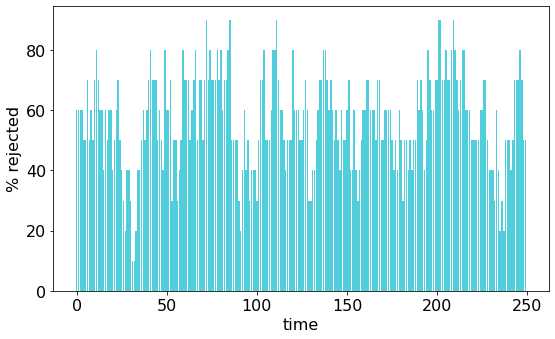

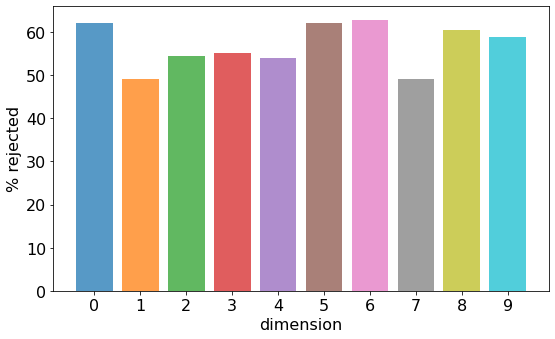

{'avg over time': 56.8, 'avg over dims': 56.8}

In [16]:
plotStatTest(nt_met, save="met_normt")

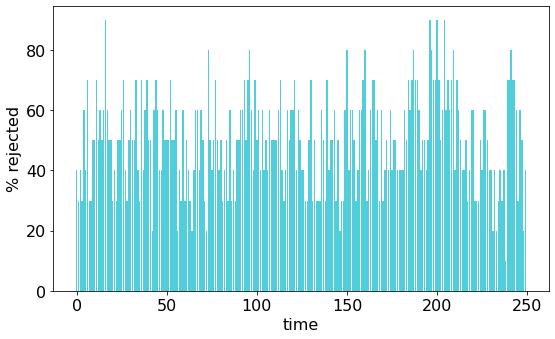

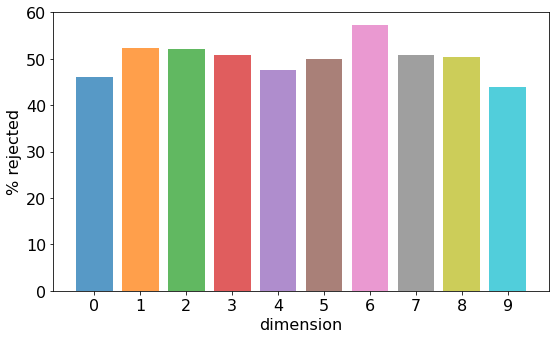

{'avg over time': 50.12, 'avg over dims': 50.11999999999999}

In [17]:
plotStatTest(nt_ehmm, save="ehmm_normt")

/var/folders/cj/vfqx8gc938b8xyvdtnybphkr0000gn/T/ipykernel_63088/3565489697.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  mtrx = pd.plotting.scatter_matrix(df, ax=ax, alpha=0.2, diagonal="hist", hist_kwds={"bins":50})


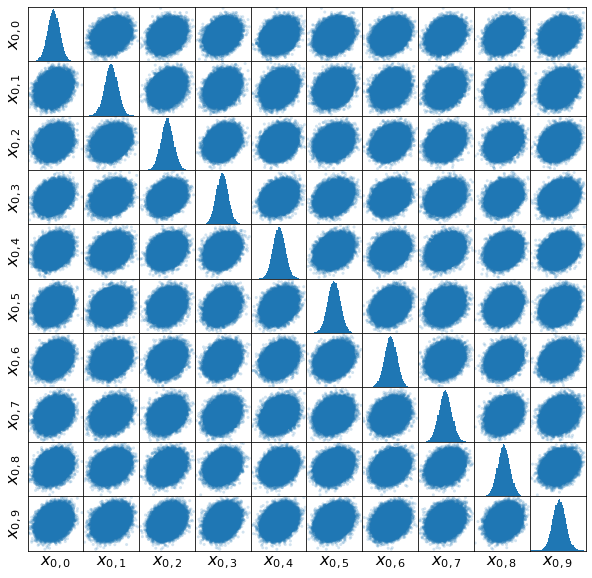

/var/folders/cj/vfqx8gc938b8xyvdtnybphkr0000gn/T/ipykernel_63088/3565489697.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  mtrx = pd.plotting.scatter_matrix(df, ax=ax, alpha=0.2, diagonal="hist", hist_kwds={"bins":50})


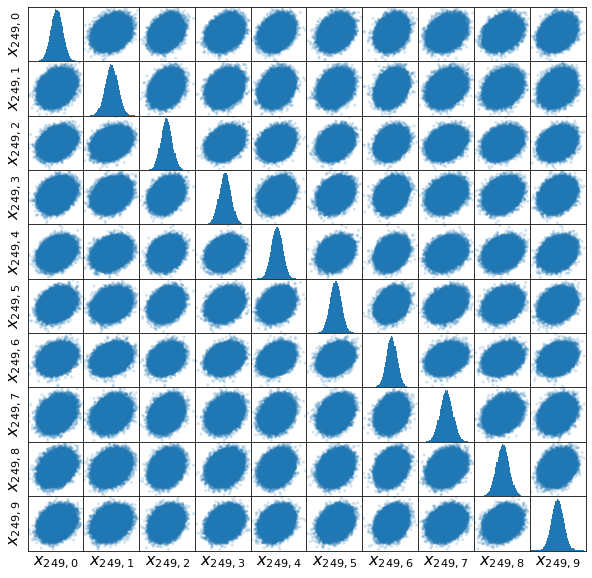

/var/folders/cj/vfqx8gc938b8xyvdtnybphkr0000gn/T/ipykernel_63088/3565489697.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  mtrx = pd.plotting.scatter_matrix(df, ax=ax, alpha=0.2, diagonal="hist", hist_kwds={"bins":50})


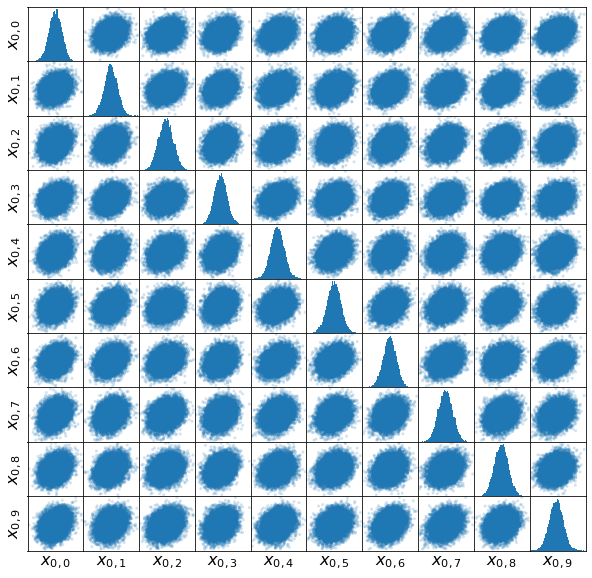

/var/folders/cj/vfqx8gc938b8xyvdtnybphkr0000gn/T/ipykernel_63088/3565489697.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  mtrx = pd.plotting.scatter_matrix(df, ax=ax, alpha=0.2, diagonal="hist", hist_kwds={"bins":50})


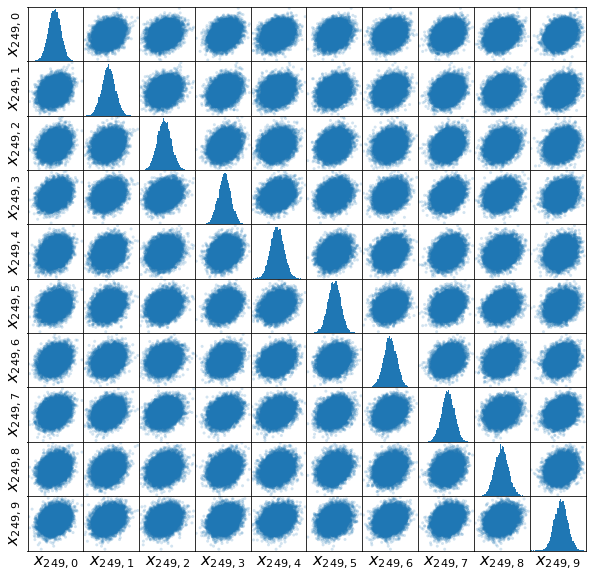

In [52]:
# Check for normality
for sampler, series in {"met":met_samples, "ehmm":ehmm_samples}.items():
    for time in [0, 249]:
        plotScatterMatrix(series, time, sampler)